In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
import sys, os, time
sys.path.append("..")
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import fiona
import fiona.transform
import shapely
import shapely.geometry
from rtree.index import Index

from scipy.stats import spearmanr

In [2]:
%%time
county_fips = []
county_shapes = []
with fiona.open("../data/county_boundaries/cb_2018_us_county_5m.shp") as f:
    print(f.crs)
    for row in f:
        county_fips.append(row["properties"]["GEOID"])
        county_shapes.append(shapely.geometry.shape(fiona.transform.transform_geom(f.crs, "epsg:4326", row["geometry"])))

{'init': 'epsg:4269'}
CPU times: user 41 s, sys: 236 ms, total: 41.2 s
Wall time: 55.7 s


In [3]:
len(county_shapes)

3233

In [4]:
%%time
prediction_shapes = []
prediction_shape_areas = []
with fiona.open("../output/full-usa-3-13-2021_filtered_deduplicated.gpkg") as f:
    print(f.crs)
    for row in f:
        prediction_shapes.append(shapely.geometry.shape(row["geometry"]))
        prediction_shape_areas.append(row["properties"]["rectangle_area"])

{'init': 'epsg:4326'}
CPU times: user 15.2 s, sys: 232 ms, total: 15.4 s
Wall time: 15.4 s


In [5]:
len(prediction_shapes)

360857

In [6]:
%%time
index = Index()
for i, county_shape in enumerate(county_shapes):
    index.insert(i, county_shape.bounds)

prediction_to_county_idx_map = []
for prediction_idx, prediction in enumerate(prediction_shapes):
    if prediction_idx % 50000 == 0:
        print(prediction_idx)
    
    matched_idx = None
    for county_idx in index.intersection(prediction.bounds):
        county = county_shapes[county_idx]
        if county.contains(prediction) or county.intersects(prediction):
            matched_idx = county_idx
            break
    prediction_to_county_idx_map.append(matched_idx)

0
50000
100000
150000
200000
250000
300000
350000
CPU times: user 55.6 s, sys: 39.8 ms, total: 55.6 s
Wall time: 55.6 s


In [7]:
summed_area_by_county = defaultdict(float)
counts_by_county = defaultdict(int)
for i, county_idx in enumerate(prediction_to_county_idx_map):
    
    if county_idx is not None:    
        county_geoid = county_fips[county_idx]
        area = prediction_shape_areas[i]

        summed_area_by_county[county_geoid] += area
        counts_by_county[county_geoid] += 1

In [8]:
len(summed_area_by_county)

3018

## Merge with AgCensus

In [9]:
df = pd.read_csv(
    "../data/agcensus_data/agcensus_2017_chickens.csv",
    dtype={
        "State ANSI": str,
        "County ANSI": str
    }
)
df["GEOID"] = df["State ANSI"] + df["County ANSI"]
df.set_index("GEOID", inplace=True)
df = df[~pd.isna(df.index)]

In [10]:
cis = sorted(list(map(float,sorted(df["CV (%)"].unique())[2:])))

## Totals

In [116]:
def get_totals(max_ci=float('inf')):

    data_item_keys = [
        "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY",
        "CHICKENS, BROILERS - OPERATIONS WITH INVENTORY",
        "CHICKENS, PULLETS, REPLACEMENT - OPERATIONS WITH INVENTORY"
    ]
    
    df = pd.read_csv(
        "../data/agcensus_data/agcensus_2017_chickens.csv",
        dtype={
            "State ANSI": str,
            "County ANSI": str
        }
    )
    df["GEOID"] = df["State ANSI"] + df["County ANSI"]
    df.set_index("GEOID", inplace=True)
    df = df[~pd.isna(df.index)]
    
    
    # Labeled values
    totals = defaultdict(int)
    for data_item_key in data_item_keys:
        mask = (df["Data Item"] == data_item_key) & (df["Domain"] == "TOTAL")
        sub_df = df[mask]

        for geoid in county_fips:
            gt_count = 0
            ci = 100
            if geoid in sub_df.index:
                gt_count = float(sub_df["Value"][geoid].replace(",",""))

                ci = sub_df["CV (%)"][geoid]
                if ci in ["(L)", "(H)"]:
                    ci = 100
                else:
                    ci = float(ci)

            if ci < max_ci:
                totals[geoid] += gt_count

    totals = np.array([totals[fips] for fips in county_fips])
    return totals

## Layers

In [12]:
options = [
    'INVENTORY: (1 TO 49 HEAD)',
    'INVENTORY: (50 TO 99 HEAD)',
    'INVENTORY: (100 TO 399 HEAD)',
    'INVENTORY: (400 TO 3,199 HEAD)',
    'INVENTORY: (3,200 TO 9,999 HEAD)',
    'INVENTORY: (10,000 TO 19,999 HEAD)',
    'INVENTORY: (20,000 TO 49,999 HEAD)',
    'INVENTORY: (50,000 TO 99,999 HEAD)',
    'INVENTORY: (100,000 OR MORE HEAD)',
]

column_names = [
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (1 TO 49 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (50 TO 99 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (100 TO 399 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (400 TO 3,199 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (3,200 TO 9,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (10,000 TO 19,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (20,000 TO 49,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (50,000 TO 99,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (100,000 OR MORE HEAD)',
]

In [13]:
data_item_key = "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY"

columns = {
    "county_fips": county_fips,
    "predicted_barns": [], 
    "predicted_barn_area": [],
    "total_agcensus_facilities": get_totals(),
}
for key in column_names:
    columns[key] = []

# Predicted values
for geoid in county_fips:
    columns["predicted_barns"].append(counts_by_county[geoid])
    columns["predicted_barn_area"].append(summed_area_by_county[geoid])
    
# Labeled values
for option, key in zip(options, column_names):
    mask = (df["Data Item"] == data_item_key) & (df["Domain Category"] == option)
    sub_df = df[mask]
    
    for geoid in county_fips:
        if geoid in sub_df.index:
            gt_count = float(sub_df["Value"][geoid].replace(",",""))
        else:
            gt_count = 0
        columns[key].append(gt_count)
df = pd.DataFrame(columns)
df.set_index("county_fips", inplace=True)

## Compute cumulative columns

In [14]:
cumulative_column_names = [
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 1 head",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 50 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 100 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 400 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 3,200 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 10,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 20,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 50,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 100,000 heads"
]

for i in range(9):
    new_column = df[column_names[i]].copy()
    for j in range(i+1, 9):
        key = column_names[j]
        new_column += df[key]
        
    df[cumulative_column_names[i]] = new_column

In [15]:
df.to_csv("../results/correlations_with_agcensus.csv")

## Correlations

In [16]:
column_names = [
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (1 TO 49 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (50 TO 99 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (100 TO 399 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (400 TO 3,199 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (3,200 TO 9,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (10,000 TO 19,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (20,000 TO 49,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (50,000 TO 99,999 HEAD)',
    'CHICKENS, LAYERS - OPERATIONS WITH INVENTORY: (100,000 OR MORE HEAD)',
]
cumulative_column_names = [
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 1 head",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 50 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 100 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 400 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 3,200 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 10,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 20,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 50,000 heads",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 100,000 heads"
]

In [17]:
df = pd.read_csv("../results/correlations_with_agcensus.csv", dtype={
    "county_fips": str,
})
df.set_index("county_fips", inplace=True)

In [145]:
xs = []
ys = []
ns = []

for ci in cis:

    y_pred = df["predicted_barns"].values
    y_test = get_totals(ci)
    mask = y_test > 0

    ns.append(mask.sum())
    
    rho, p = spearmanr(
        y_pred[mask],
        y_test[mask]
    )
    xs.append(ci)
    ys.append(rho)

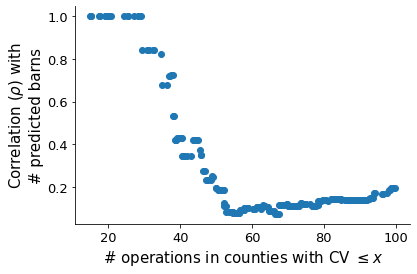

In [147]:
fig, ax = plt.subplots(1,1,figsize=(6,4),facecolor="white")
plt.scatter(xs, ys)
plt.ylabel("Correlation ($\\rho$) with\n# predicted barns", fontsize=15)
plt.xlabel("# operations in counties with CV $\leq x$", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig('agcensus-correlations_different_cvs.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [148]:
ys = []
for i in range(9):
    
    predicted_counts = df["predicted_barns"].values
    predicted_areas = df["predicted_barn_area"].values
    
    agcensus_facilities = df[cumulative_column_names[i]].values
    
    print(cumulative_column_names[i])
    rho, p = spearmanr(predicted_areas, agcensus_facilities)
    print(f"All counties (n={predicted_areas.shape[0]}): {rho:0.4f} ({p:0.4f})")
    
    
    mask = (agcensus_facilities > 0)
    agcensus_facilities = agcensus_facilities[mask]
    predicted_areas = predicted_areas[mask]
    predicted_counts = predicted_counts[mask]
    
    rho, p = spearmanr(predicted_counts, agcensus_facilities)
    print(f"AgCensus non-zero counties (n={mask.sum()}): {rho:0.4f} ({p:0.4f})")
    print("")
    
    ys.append(rho)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 1 head
All counties (n=3233): 0.2343 (0.0000)
AgCensus non-zero counties (n=3036): 0.1137 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 50 heads
All counties (n=3233): 0.2519 (0.0000)
AgCensus non-zero counties (n=2640): 0.1250 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 100 heads
All counties (n=3233): 0.2575 (0.0000)
AgCensus non-zero counties (n=2084): 0.1457 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 400 heads
All counties (n=3233): 0.3272 (0.0000)
AgCensus non-zero counties (n=1132): 0.2889 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 3,200 heads
All counties (n=3233): 0.3863 (0.0000)
AgCensus non-zero counties (n=725): 0.3613 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 10,000 heads
All counties (n=3233): 0.4038 (0.0000)
AgCensus non-zero counties (n=663): 0.4006 (0.0000)

CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 20,000 heads
All counties (n=3233): 0.3999 (0.0

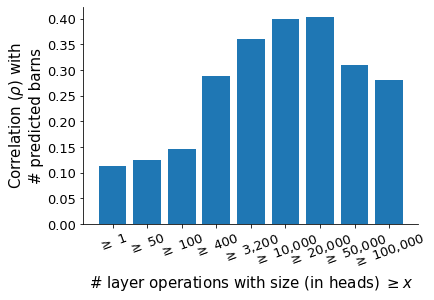

In [149]:
xs = [
    "$\geq$ 1",
    "$\geq$ 50",
    "$\geq$ 100",
    "$\geq$ 400",
    "$\geq$ 3,200",
    "$\geq$ 10,000",
    "$\geq$ 20,000",
    "$\geq$ 50,000",
    "$\geq$ 100,000"
]

fig, ax = plt.subplots(1,1,figsize=(6,4),facecolor="white")
plt.bar(xs, ys)
plt.xticks(rotation=20, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Correlation ($\\rho$) with\n# predicted barns", fontsize=15)
plt.xlabel("# layer operations with size (in heads) $\geq x$", fontsize=15)
#plt.title("Correlation between predicted areas and\nCoA facility counts by county", fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig('agcensus-correlations_different_sizes.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

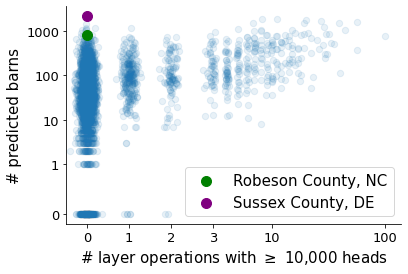

In [159]:
df = pd.read_csv("../results/correlations_with_agcensus.csv", dtype={
    "county_fips": str,
})
df.set_index("county_fips", inplace=True)
robeson_fips = "37155" 
sussex_fips = "10005"

y_pred = df['predicted_barns']
y_true = df['CHICKENS, LAYERS - OPERATIONS WITH INVENTORY >= 10,000 heads']

fig, ax = plt.subplots(1,1,figsize=(6,4),facecolor="white")

plt.scatter(y_true.values + np.random.randn(y_true.values.shape[0])/10, y_pred.values, alpha=0.1, s=40)
plt.scatter(y_true[robeson_fips], y_pred[robeson_fips], s=100, c='green', label='Robeson County, NC')
plt.scatter(y_true[sussex_fips], y_pred[sussex_fips], s=100, c='purple', label='Sussex County, DE')

plt.yscale("symlog",linthresh=1)
plt.xscale("symlog",linthresh=3)
plt.xlim([-0.5,None])

plt.xticks([0,1,2,3,10,100], [0,1,2,3,10,100], fontsize=13)
plt.yticks([0,1,10,100,1000], [0,1,10,100,1000], fontsize=13)
plt.xlabel('# layer operations with $\geq$ 10,000 heads', fontsize=15)
plt.ylabel('# predicted barns', fontsize=15)
plt.legend(fontsize=15)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig('agcensus-barns_vs_operations.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()